In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
import splitfolders
import copy
import pathlib
import itertools
import warnings

warnings.filterwarnings('ignore')

In [2]:
labels_df = pd.read_csv('brian-tumor-dataset/metadata.csv')
print(labels_df.head())

   Unnamed: 0            image  class format mode          shape
0           0   Cancer (1).jpg  tumor   JPEG  RGB  (512, 512, 3)
1           1   Cancer (1).png  tumor    PNG    L     (300, 240)
2           2   Cancer (1).tif  tumor   TIFF  RGB  (256, 256, 3)
3           3  Cancer (10).jpg  tumor   JPEG  RGB  (512, 512, 3)
4           4  Cancer (10).tif  tumor   TIFF  RGB  (256, 256, 3)


In [3]:
data_dir = pathlib.Path('brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set')
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8,0.2))

data_dir = pathlib.Path('brain')
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:02, 1750.76 files/s]


In [4]:
# data transformations pipeline
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# load datasets
train_set = ImageFolder(data_dir / 'train', transform=transform)
val_set = ImageFolder(data_dir / 'val', transform=transform)

In [28]:
# dataloader
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

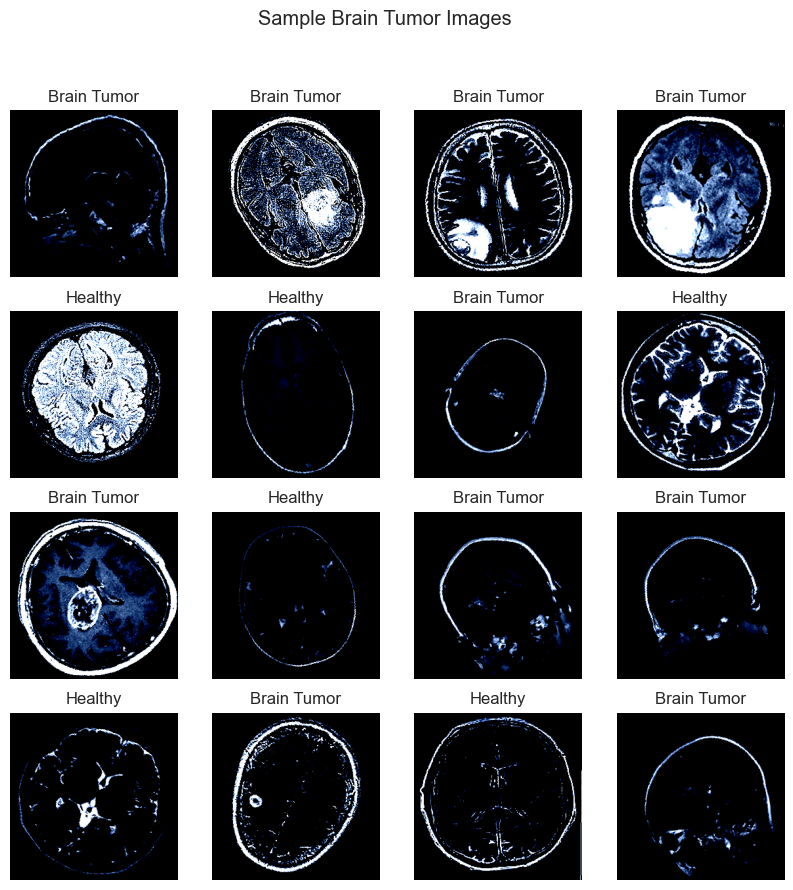

In [7]:
# visualize train images
def visualize_images(dataset, label_map, rows=4, cols=4):
    fig = plt.figure(figsize=(10,10))
    for i in range(1, rows * cols + 1):
        idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[idx]
        img_np = img.numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)

        ax = fig.add_subplot(rows, cols, i)
        ax.set_title(label_map[label])
        ax.axis('off')
        ax.imshow(img_np)
    
    plt.suptitle('Sample Brain Tumor Images')
    plt.show()

CLA_label = {0: 'Brain Tumor', 1:'Healthy'}
visualize_images(train_set, CLA_label)

In [8]:
class CNN_TUMOR(nn.Module):
    def __init__(self, params):
        super(CNN_TUMOR, self).__init__()
        Cin, Hin, Win = params['input_shape']
        init_f = params['init_filters']
        num_fc1 = params['fc_units']
        num_classes = params['num_classes']
        self.dropout_rate = params['dropout_rate']
        
        # convolutional layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        self.conv2 = nn.Conv2d(init_f, init_f * 2, kernel_size=3)
        self.conv3 = nn.Conv2d(init_f * 2, init_f * 4, kernel_size=3)
        self.conv4 = nn.Conv2d(init_f * 4, init_f * 8, kernel_size=3)
        
        # flatten size calculation
        h, w = self._conv_output_shape(Hin, Win)
        self.num_flatten = h * w * init_f * 8
        
        # fully connected layers
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def _conv_output_shape(self, h, w):
        def conv_shape(h, w, layer):
            h = (h - layer.kernel_size[0] + 2 * layer.padding[0]) // layer.stride[0] + 1
            w = (w - layer.kernel_size[1] + 2 * layer.padding[1]) // layer.stride[1] + 1
            return h // 2, w // 2  # after max-pooling

        for conv in [self.conv1, self.conv2, self.conv3, self.conv4]:
            h, w = conv_shape(h, w, conv)
        
        return h, w

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        
        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate)
        return F.log_softmax(self.fc2(x), dim=1)

In [9]:
# training and Validation Function
def train_val(model, params, device):
    optimizer = params['optimizer']
    loss_func = params['loss_func']
    lr_scheduler = params['lr_scheduler']
    epochs = params['epochs']
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in tqdm(range(epochs), desc="Training"):
        # training phase
        model.train()
        train_loss, train_correct = 0, 0
        
        for imgs, labels in params['train_loader']:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        
        # validation phase
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for imgs, labels in params['val_loader']:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                val_loss += loss_func(outputs, labels).item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()
        
        # learning rate scheduler
        lr_scheduler.step(val_loss)
        
        # update best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        # logging
        train_acc = train_correct / len(params['train_loader'].dataset)
        val_acc = val_correct / len(params['val_loader'].dataset)
        history['train_loss'].append(train_loss / len(params['train_loader']))
        history['val_loss'].append(val_loss / len(params['val_loader']))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
    
    model.load_state_dict(best_model_wts)
    return model, history

In [10]:
# hyperparams and initalization
params_model = {
    'input_shape': (3, 256, 256),
    'init_filters': 8,
    'fc_units': 100,
    'num_classes': 2,
    'dropout_rate': 0.25
}

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = CNN_TUMOR(params_model).to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=1)
loss_func = nn.NLLLoss()

In [12]:
params_train = {
    'train_loader': train_loader,
    'val_loader': val_loader,
    'optimizer': optimizer,
    'lr_scheduler': lr_scheduler,
    'loss_func': loss_func,
    'epochs': 50
}

In [13]:
# train and validate
cnn_model, history = train_val(cnn_model, params_train, device)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

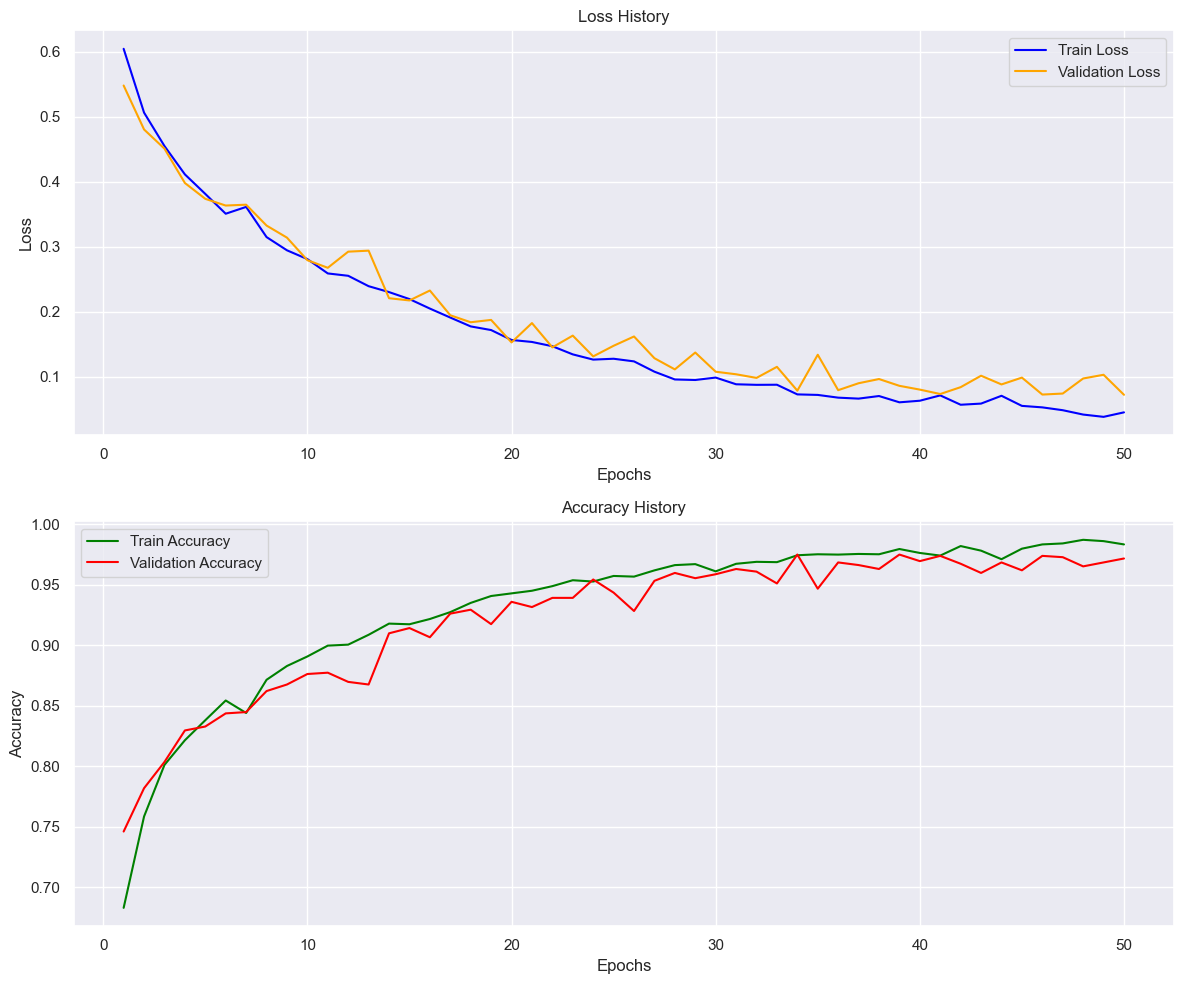

In [22]:
def plot_history(history):
    required_keys = ['train_loss', 'val_loss', 'train_acc', 'val_acc']
    if not all(key in history for key in required_keys):
        print("History dictionary is missing required keys.")
        return

    # extract loss and acc from the history dictionary
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_acc = history['train_acc']
    val_acc = history['val_acc']

    epochs = range(1, len(train_loss) + 1)

    # create subplots
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    # plot loss
    axs[0].plot(epochs, train_loss, label='Train Loss', color='blue')
    axs[0].plot(epochs, val_loss, label='Validation Loss', color='orange')
    axs[0].set_title('Loss History')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # plot acc
    axs[1].plot(epochs, train_acc, label='Train Accuracy', color='green')
    axs[1].plot(epochs, val_acc, label='Validation Accuracy', color='red')
    axs[1].set_title('Accuracy History')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

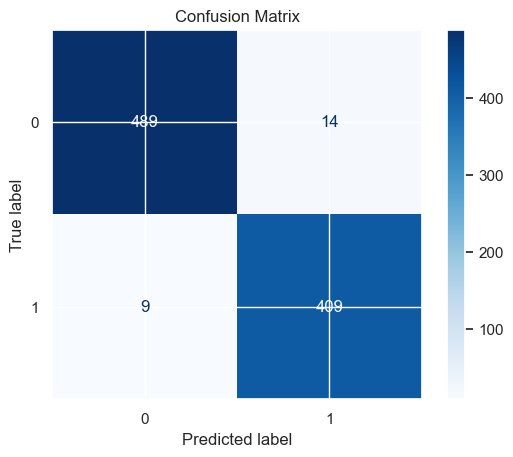

In [32]:
all_preds = []
all_labels = []

cnn_model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = cnn_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLA_label)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()